In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import glob, os
import numpy as np

In [202]:
from __future__ import print_function
import numpy as np

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import RegexpTokenizer

# Read data

In [2]:
datadir_T1 = '/home/ana/eRisk/data/eRisk2020_T1_train/eRISK2020_T1_training_data/eRISK2020_training_data/data/'
labels_file_T1 = '/home/ana/eRisk/data/eRisk2020_T1_train/eRISK2020_T1_training_data/eRISK2020_training_data/golden_truth.txt'

In [52]:
labels_T1 = pd.read_csv(labels_file_T1, delimiter=' ', names=['subject', 'label'])

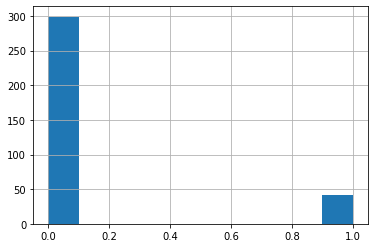

In [53]:
labels_T1.label.hist()

In [54]:
labels_T1 = labels_T1.set_index('subject')
labels_T1

,label
subject,
subject671,1
subject9917,1
subject6238,1
subject8581,1
subject7238,1
...,...
subject2182,0
subject9829,0
subject3270,0


## Read text

In [5]:
writings = []
for subject_file in os.listdir(datadir_T1):
    print(subject_file)
    with open(os.path.join(datadir_T1, subject_file)) as sf:
        contents = sf.read()
        root = ET.fromstring(contents)
        try:
            subject = root.findall('ID')[0].text
        except Exception:
            print('Cannot extract ID', contents[:500], '\n-------\n')        
        for w in root.iter('WRITING'):
            subject_writings = {'subject': subject}
            for title in w.findall('TITLE'):
                subject_writings['title'] = title.text
            for text in w.findall('TEXT'):
                subject_writings['text'] = text.text
            for date in w.findall('DATE'):
                subject_writings['date'] = date.text
            writings.append(subject_writings)
            # TODO: Date



subject8292.xml
subject6644.xml
subject7982.xml
subject9260.xml
subject9918.xml
subject4284.xml
subject9829.xml
subject7661.xml
subject8361.xml
subject4831.xml
subject2181.xml
subject9077.xml
subject2922.xml
subject2238.xml
subject4513.xml
subject269.xml
subject2678.xml
subject9197.xml
subject4143.xml
subject2605.xml
subject4226.xml
subject7627.xml
subject5150.xml
subject4510.xml
subject2182.xml
subject280.xml
subject1105.xml
subject187.xml
subject8001.xml
subject9285.xml
subject2621.xml
subject4414.xml
subject2685.xml
subject9961.xml
subject8065.xml
subject8225.xml
subject6866.xml
subject9949.xml
subject1507.xml
subject8329.xml
subject9411.xml
subject7857.xml
subject1545.xml
subject9811.xml
subject5000.xml
subject4843.xml
subject569.xml
subject51.xml
subject9156.xml
subject6453.xml
subject1210.xml
subject5528.xml
subject1485.xml
subject5935.xml
subject4527.xml
subject3301.xml
subject4074.xml
subject6093.xml
subject2088.xml
subject8990.xml
subject6459.xml
subject7830.xml
subject8395.xm

In [6]:
writings_df = pd.DataFrame(writings)

In [7]:
writings_df

,subject,title,date,text
0,subject8292,If anyone could help with which sub to put thi...,2016-08-02 09:22:12,NaN
1,subject8292,I'm literally never gonna stop waiting...,2016-08-05 09:35:55,NaN
2,subject8292,This is a really interesting study! Makes sens...,2016-08-05 21:36:24,NaN
3,subject8292,The only thing Frank is building ...,2016-08-07 23:35:23,"... Is hype. Think about it, every time he wor..."
4,subject8292,Mostly always me during this whole charade,2016-08-09 08:39:41,NaN
...,...,...,...,...
170693,subject217,NaN,2018-08-19 11:29:21,"this is my personal experience ,it may not ref..."
170694,subject217,NaN,2018-08-19 16:17:34,stop looking at 20 million saudis as one entit...
170695,subject217,NaN,2018-08-19 20:00:31,i am aware of stats now and then. i was just s...
170696,subject217,WHAT DID YOU SAY TO ME?,2018-08-20 10:54:11,NaN


In [77]:
writings_df['label'] = writings_df['subject'].apply(
    lambda s: labels_T1.loc[s, 'label'])

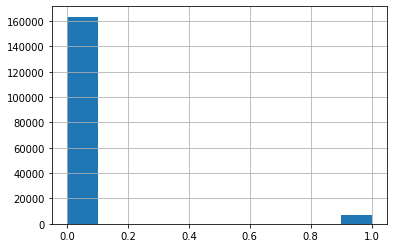

In [79]:
writings_df.label.hist()

In [203]:
tokenizer = RegexpTokenizer(r'\w+')

def tokenize(t):
    return tokenizer.tokenize(t.lower())

In [204]:
tokenize("I wasn't ready to leave! buh-buw(dd). Sasa .")

['i', 'wasn', 't', 'ready', 'to', 'leave', 'buh', 'buw', 'dd', 'sasa']

In [205]:
writings_df['tokenized_title'] = writings_df['title'].apply(lambda t: tokenize(t) if type(t)==str else [])
writings_df['title_len'] = writings_df['tokenized_title'].apply(lambda t: len(t))
writings_df['tokenized_text'] = writings_df['text'].apply(lambda t: tokenize(t) if type(t)==str else [])
writings_df['text_len'] = writings_df['tokenized_text'].apply(lambda t: len(t)) # TODO: exclude the ones without a title from the statistic?

In [206]:
writings_df.text_len.describe()

count    170698.000000
mean         24.186101
std          72.856749
min           0.000000
25%           0.000000
50%           8.000000
75%          23.000000
max        7201.000000
Name: text_len, dtype: float64

In [207]:
writings_df.title_len.describe()

count    170698.000000
mean          3.119205
std           6.983101
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max         149.000000
Name: title_len, dtype: float64

In [208]:
writings_df.groupby('subject').mean()

,title_len,text_len,label
subject,,,
subject0,0.141434,31.553785,0.0
subject1027,2.970588,0.735294,0.0
subject1055,0.416667,79.316667,0.0
subject1064,4.727273,60.636364,1.0
subject1089,2.569231,10.400000,0.0
...,...,...,...
subject9917,3.702703,93.864865,1.0
subject9918,0.218023,11.520349,0.0
subject992,0.902377,17.716469,0.0


# Recurrent NN

### Test network

In [273]:
max_features = 20000
# cut texts after this number of words
# (among top max_features most common words)
maxlen = 100
batch_size = 64

In [274]:
# Load data with np.load from old version of tf...

def load_imdb_data():
    print('Loading data...')

    import numpy as np
    # save np.load
    np_load_old = np.load

    # modify the default parameters of np.load
    np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

    # call load_data with allow_pickle implicitly set to true
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

    # restore np.load for future normal usage
    np.load = np_load_old
    return (x_train, y_train), (x_test, y_test)




In [275]:
from collections import Counter
def load_erisk_data(writings_df, voc_size, train_prop=0.7):
    print("Loading data...")
    vocabulary = {}
    word_freqs = Counter()
    for words in writings_df.tokenized_text:
        word_freqs.update(words)
    i = 1
    for w, f in word_freqs.most_common(voc_size-1):
        vocabulary[w] = i
        i += 1
    data_train = []
    data_test = []
    labels_train = []
    labels_test = []
    # TODO: shuffle?
    all_subjects = list(set(writings_df.subject))
    training_subjects_size = int(len(all_subjects) * train_prop)
    training_subjects = all_subjects[:training_subjects_size]
    training_rows = writings_df[writings_df['subject'].isin(training_subjects)]
    test_rows = writings_df[~writings_df['subject'].isin(training_subjects)]
    for row in training_rows.itertuples():
        words = row.tokenized_text
        if not words:
            continue
        label = row.label
        # Using 0 for OOV token
        data_train.append([vocabulary.get(w, 0) for w in words])
        labels_train.append(label)
    for row in test_rows.itertuples():
        words = row.tokenized_text
        if not words:
            continue
        label = row.label
        # Using 0 for OOV token
        data_test.append([vocabulary.get(w, 0) for w in words])
        labels_test.append(label)
        
    return (data_train, labels_train), (data_test, labels_test)

In [276]:
# (x_train, y_train), (x_test, y_test) = load_imdb_data()

In [277]:
(x_train, y_train), (x_test, y_test) = load_erisk_data(writings_df, voc_size=max_features)

Loading data...


In [278]:
x_train

[[29,
  15,
  11,
  1,
  113,
  160,
  2,
  39,
  412,
  18,
  3102,
  16,
  369,
  27,
  4,
  1385,
  10,
  0,
  166,
  7,
  3,
  12506,
  395,
  2,
  39,
  237,
  3,
  253,
  27,
  4,
  0,
  0,
  17,
  2,
  1192,
  8,
  35,
  25,
  10,
  589,
  18,
  1,
  0,
  0,
  13,
  1,
  348,
  69,
  10,
  4,
  2384,
  17,
  1,
  246,
  64,
  60,
  1138,
  60,
  1458,
  264,
  33,
  0,
  589,
  10,
  10581,
  13,
  4,
  889,
  1138,
  5,
  95,
  162,
  264,
  19,
  0,
  10,
  1,
  11268,
  2004,
  4,
  1939,
  1458,
  16,
  1,
  3702,
  2921,
  6,
  1,
  3703,
  17,
  206,
  46,
  11,
  60,
  48,
  3,
  593,
  26,
  25,
  30,
  2982,
  181,
  35,
  25,
  1677,
  1,
  589,
  108,
  2032,
  550,
  3,
  19096,
  589,
  1423,
  17,
  7,
  2541,
  47,
  4084,
  7488,
  16,
  1,
  3703,
  5,
  7,
  12,
  77,
  1800,
  19,
  0,
  170,
  14,
  101,
  3,
  7489,
  589,
  338,
  27,
  7,
  300,
  185,
  15,
  589,
  11,
  5952,
  227,
  221,
  291,
  118,
  31,
  15,
  11,
  7,
  70,
  6,
  3102,
  2,
  4

In [279]:
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

87863 train sequences
39741 test sequences


In [280]:
print(pd.Series(y_train).sum(), "positive training examples")
print(pd.Series(y_test).sum(), "positive test examples")

5491 positive training examples
1454 positive test examples


In [281]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

Pad sequences (samples x time)


In [282]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)

x_train shape: (87863, 100)
x_test shape: (39741, 100)


In [283]:
# from sklearn.utils import class_weight

# list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
# y = train[list_classes].values
# sample_weights = class_weight.compute_sample_weight('balanced', y)

In [284]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [285]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))


In [286]:
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [290]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [291]:
# try using different optimizers and different optimizer configs
model.compile('adam', 'binary_crossentropy',
              metrics=['binary_accuracy', f1_m, precision_m, recall_m])

In [ ]:
print('Train...')
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=4, class_weight={0:0.5, 1:8},
          validation_data=[x_test, y_test],
                   workers=4)

Train...
Train on 87863 samples, validate on 39741 samples
Epoch 1/4
87863/87863 [==============================] - 1669s 19ms/sample - loss: 0.6306 - binary_accuracy: 0.6652 - f1_m: 0.1850 - precision_m: 0.1158 - recall_m: 0.6055 - val_loss: 0.4869 - val_binary_accuracy: 0.7740 - val_f1_m: 0.0984 - val_precision_m: 0.0614 - val_recall_m: 0.3228
Epoch 2/4
87863/87863 [==============================] - 1645s 19ms/sample - loss: 0.5200 - binary_accuracy: 0.7234 - f1_m: 0.2475 - precision_m: 0.1550 - recall_m: 0.7403 - val_loss: 0.5121 - val_binary_accuracy: 0.7180 - val_f1_m: 0.0921 - val_precision_m: 0.0546 - val_recall_m: 0.3733
Epoch 3/4
 9216/87863 [==>...........................] - ETA: 24:34 - loss: 0.3981 - binary_accuracy: 0.7942 - f1_m: 0.3293 - precision_m: 0.2147 - recall_m: 0.8222

In [252]:
predictions = model.predict(x_test[:1000])

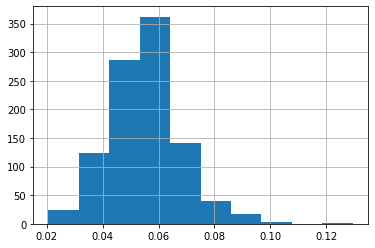

In [253]:
pd.Series(predictions.flatten()).hist()

In [255]:
sum(predictions>0.5)

array([0])

In [256]:
class_weights

array([0.5333305 , 8.00063741])